In [196]:
# Import packages
from datetime import datetime
import pandas as pd
import numpy as np
import statsmodels.api as sm
import os

In [197]:
# Import facilities dataset
fac = pd.read_csv("./Data/facilities.csv")
fac.head()

,station_id,name,street,zip,city,ticket_vending_machine,luggage_lockers,free_parking,taxi,bicycle_spots,...,sales_open_wednesday,sales_close_wednesday,sales_open_thursday,sales_close_thursday,sales_open_friday,sales_close_friday,sales_open_saturday,sales_close_saturday,sales_open_sunday,sales_close_sunday
0,8734201,Arras,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,8015345,Aachen Hbf,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,8895000,Aalst,Stationsplein 9,9300,Aalst,1.0,0.0,1.0,1.0,1.0,...,05:45,20:00,05:45,20:00,05:45,20:00,06:00,20:00,06:00,20:00
3,8895125,Aalst-Kerrebroek,Ledebaan,9300,Aalst,0.0,0.0,1.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,8891140,Aalter,Stationsplein 2,9880,Aalter,1.0,0.0,1.0,0.0,1.0,...,07:00,14:15,07:00,14:15,07:00,14:15,07:45,15:00,07:45,15:00


In [198]:
# Check number of missing values per variable
for col in fac.columns:
    missings = len(fac[col][fac[col].isnull()]) / float(len(fac))
    print(col, missings)

# All sales_* columns have a very high number of missing values indicating a data quality issue. 

station_id 0.0
name 0.0
street 0.17210682492581603
zip 0.17359050445103857
city 0.17359050445103857
ticket_vending_machine 0.16765578635014836
luggage_lockers 0.16765578635014836
free_parking 0.16765578635014836
taxi 0.16765578635014836
bicycle_spots 0.16765578635014836
blue-bike 0.16765578635014836
bus 0.16765578635014836
tram 0.16765578635014836
metro 0.16765578635014836
wheelchair_available 0.16765578635014836
ramp 0.16765578635014836
disabled_parking_spots 0.16765578635014836
elevated_platform 0.16765578635014836
escalator_up 0.16765578635014836
escalator_down 0.16765578635014836
elevator_platform 0.16765578635014836
audio_induction_loop 0.16765578635014836
sales_open_monday 0.7997032640949555
sales_close_monday 0.7997032640949555
sales_open_tuesday 0.7997032640949555
sales_close_tuesday 0.7997032640949555
sales_open_wednesday 0.7997032640949555
sales_close_wednesday 0.7997032640949555
sales_open_thursday 0.7997032640949555
sales_close_thursday 0.7997032640949555
sales_open_friday 

In [199]:
# Further investigation of missing values in facilities columns

# we will exclude sales_* (because of DQ issue) and determine which columns are metadata
exclude_prefix = 'sales_'
metadata = {'station_id', 'station', 'name', 'street', 'zip', 'city'}
cols_to_check = [
    c for c in fac.columns
    if not c.startswith(exclude_prefix) and c not in metadata
]

print(f"Number of columns checked: {len(cols_to_check)}")
print("Some of the checked columns:", cols_to_check[:12])

# make mask for rows with at least one NaN in those columns
nan_mask = fac[cols_to_check].isna().any(axis=1)

# make results table
id_cols = [c for c in ['station_id','station','name'] if c in fac.columns]
result_cols = id_cols + cols_to_check

nan_stations = fac.loc[nan_mask, result_cols].copy()

# add column to table that counts how many NaN's there are per station for the checked columns
nan_stations['n_missing'] = fac.loc[nan_mask, cols_to_check].isna().sum(axis=1)

nan_per_column = nan_stations[cols_to_check].isna().sum().sort_values(ascending=False).to_frame(name='n_missing_in_subset')

# overview
print("Number of stations with at least 1 NaN:", nan_stations.shape[0])
display(nan_stations.head(50)) 
display(nan_per_column)   

Number of columns checked: 17
Some of the checked columns: ['ticket_vending_machine', 'luggage_lockers', 'free_parking', 'taxi', 'bicycle_spots', 'blue-bike', 'bus', 'tram', 'metro', 'wheelchair_available', 'ramp', 'disabled_parking_spots']
Number of stations with at least 1 NaN: 113


,station_id,name,ticket_vending_machine,luggage_lockers,free_parking,taxi,bicycle_spots,blue-bike,bus,tram,metro,wheelchair_available,ramp,disabled_parking_spots,elevated_platform,escalator_up,escalator_down,elevator_platform,audio_induction_loop,n_missing
0,8734201,Arras,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,17
1,8015345,Aachen Hbf,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,17
8,8778127,Agde,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,17
9,8774176,Aime-la-Plagne,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,17
11,8731901,Aix-en-Provence TGV,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,17
12,8774164,Albertville,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,17
16,8400058,Amsterdam CS,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,17
19,8728685,Annappes,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,17
22,8775767,Antibes,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,17
37,8728686,Ascq,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,17


,n_missing_in_subset
ticket_vending_machine,113
luggage_lockers,113
free_parking,113
taxi,113
bicycle_spots,113
blue-bike,113
bus,113
tram,113
metro,113
wheelchair_available,113


In [200]:
# From the above, we see that the stations with missing facility data contain no information in all facility columns.
# Therefore, we will remove all stations with missing facility data from the dataset to perform our analysis.
# Additionally, we exclude all sales_* columns from the resulting dataframe.
sales_cols = [col for col in fac.columns if col.startswith('sales_')]
cols_to_keep = [col for col in fac.columns if col not in sales_cols]
fac_no_missing_facilities = fac.loc[~nan_mask, cols_to_keep].copy()
fac_no_missing_facilities.head()

,station_id,name,street,zip,city,ticket_vending_machine,luggage_lockers,free_parking,taxi,bicycle_spots,...,tram,metro,wheelchair_available,ramp,disabled_parking_spots,elevated_platform,escalator_up,escalator_down,elevator_platform,audio_induction_loop
2,8895000,Aalst,Stationsplein 9,9300,Aalst,1.0,0.0,1.0,1.0,1.0,...,0.0,0.0,1.0,1.0,4.0,1.0,0.0,0.0,1.0,1.0
3,8895125,Aalst-Kerrebroek,Ledebaan,9300,Aalst,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,8891140,Aalter,Stationsplein 2,9880,Aalter,1.0,0.0,1.0,0.0,1.0,...,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,1.0
5,8833209,Aarschot,Statieplein,3200,Aarschot,1.0,0.0,1.0,0.0,1.0,...,0.0,0.0,1.0,1.0,3.0,0.0,0.0,0.0,0.0,1.0
6,8892288,Aarsele,Hogenhovenstraat Zn,8700,Aarsele,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [201]:
# We transform disabled_parking_spots to a binary indicator
fac_no_missing_facilities["disabled_parking_ind"] = (fac["disabled_parking_spots"].fillna(0) > 0).astype(float)

# Binary columns
binary_cols = ["ticket_vending_machine","luggage_lockers","free_parking","taxi","bicycle_spots","blue-bike","bus","tram","metro","wheelchair_available","ramp","disabled_parking_ind","elevated_platform","escalator_up","escalator_down","elevator_platform","audio_induction_loop"]

# Sum over binary columns + disabled_parking_ind
fac_no_missing_facilities["n_facilities"] = fac_no_missing_facilities[binary_cols].sum(axis=1)
fac_no_missing_facilities


,station_id,name,street,zip,city,ticket_vending_machine,luggage_lockers,free_parking,taxi,bicycle_spots,...,wheelchair_available,ramp,disabled_parking_spots,elevated_platform,escalator_up,escalator_down,elevator_platform,audio_induction_loop,disabled_parking_ind,n_facilities
2,8895000,Aalst,Stationsplein 9,9300,Aalst,1.0,0.0,1.0,1.0,1.0,...,1.0,1.0,4.0,1.0,0.0,0.0,1.0,1.0,1.0,12.0
3,8895125,Aalst-Kerrebroek,Ledebaan,9300,Aalst,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,8891140,Aalter,Stationsplein 2,9880,Aalter,1.0,0.0,1.0,0.0,1.0,...,0.0,0.0,4.0,0.0,0.0,0.0,0.0,1.0,1.0,7.0
5,8833209,Aarschot,Statieplein,3200,Aarschot,1.0,0.0,1.0,0.0,1.0,...,1.0,1.0,3.0,0.0,0.0,0.0,0.0,1.0,1.0,9.0
6,8892288,Aarsele,Hogenhovenstraat Zn,8700,Aarsele,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
668,8832250,Zolder,Stationsstraat Z/n,3550,Heusden - Zolder,1.0,0.0,1.0,0.0,0.0,...,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,1.0,3.0
669,8832334,Zonhoven,Engstegenseweg,3520,Zonhoven,1.0,0.0,1.0,0.0,0.0,...,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,1.0,3.0
670,8895208,Zottegem,Stationsplein 12,9620,Zottegem,1.0,0.0,1.0,0.0,1.0,...,1.0,1.0,2.0,0.0,0.0,0.0,0.0,1.0,1.0,8.0
672,8894821,Zwijndrecht,Fortlaan 1,2070,Zwijndrecht,1.0,0.0,1.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0


In [202]:
# Import travelers dataset
travelers = pd.read_csv("./Data/travelers.csv", sep=";", index_col=0)
# Rename for convenience
travelers = travelers.rename({"Station": "station",
                                    "Avg number of travelers in the week": "week",
                                    "Avg number of travelers on Saturday": "saturday",
                                    "Avg number of travelers on Sunday": "sunday"}, axis=1)
travelers.head()

,station,week,saturday,sunday
0,AALST,6444.0,1768.0,1592.0
1,AALST-KERREBROEK,27.0,NaN,NaN
2,AALTER,2288.0,1055.0,855.0
3,AARSCHOT,6270.0,1954.0,1395.0
4,AARSELE,34.0,NaN,NaN


In [203]:
# Check number of missing values per variable
for col in travelers.columns:
    missings = len(travelers[col][travelers[col].isnull()]) / float(len(travelers))
    print(col, missings)

station 0.0
week 0.003616636528028933
saturday 0.11392405063291139
sunday 0.11211573236889692


In [204]:
# Further inspection on Wikipedia and the NMBS website reveal that there are no train rides on these dates for these stations. 
# For example, Baasrode-Zuid & Buda only have train rides during the week and none in the weekend. 
# Therefore, we will impute every missing value with zero.
travelers['week'] = travelers['week'].fillna(0)
travelers['saturday'] = travelers['saturday'].fillna(0)
travelers['sunday'] = travelers['sunday'].fillna(0)

# Show
travelers.head()

,station,week,saturday,sunday
0,AALST,6444.0,1768.0,1592.0
1,AALST-KERREBROEK,27.0,0.0,0.0
2,AALTER,2288.0,1055.0,855.0
3,AARSCHOT,6270.0,1954.0,1395.0
4,AARSELE,34.0,0.0,0.0


In [205]:
# Create total travelers over the week
travelers["week_total"] = 5 * travelers["week"] + travelers["saturday"] + travelers["sunday"]

In [206]:
# Get avg travelers per day (including weekends)
travelers["avg_day"] = travelers["week_total"] / float(7)
travelers

,station,week,saturday,sunday,week_total,avg_day
0,AALST,6444.0,1768.0,1592.0,35580.0,5082.857143
1,AALST-KERREBROEK,27.0,0.0,0.0,135.0,19.285714
2,AALTER,2288.0,1055.0,855.0,13350.0,1907.142857
3,AARSCHOT,6270.0,1954.0,1395.0,34699.0,4957.000000
4,AARSELE,34.0,0.0,0.0,170.0,24.285714
...,...,...,...,...,...,...
548,ZINGEM,523.0,98.0,86.0,2799.0,399.857143
549,ZOLDER,123.0,38.0,37.0,690.0,98.571429
550,ZONHOVEN,67.0,29.0,19.0,383.0,54.714286
551,ZOTTEGEM,4936.0,986.0,931.0,26597.0,3799.571429


In [207]:
# Import stations dataset
stations = pd.read_csv("./Data/stations.csv")
stations.head()

,station_id,name,alternative-fr,alternative-nl,alternative-de,alternative-en,country-code,longitude,latitude,avg_stop_times,official_transfer_time
0,8101003,Wien Hbf,NaN,NaN,NaN,NaN,at,16.375864,48.184923,0.000000,0.0
1,8734201,Arras,NaN,NaN,NaN,NaN,fr,2.781690,50.286830,0.014925,120.0
2,8015345,Aachen Hbf,Aix-la-Chapelle Hbf,Aken Hbf,NaN,NaN,de,6.105275,50.770832,30.268657,300.0
3,8895000,Aalst,Alost,NaN,NaN,NaN,be,4.039653,50.942813,157.425373,300.0
4,8895125,Aalst-Kerrebroek,Alost Kerrebroek,NaN,NaN,NaN,be,4.024407,50.948377,7.731343,300.0


In [208]:
stations["daily_trains"] = stations["avg_stop_times"]
stations["daily_trains"]

0        0.000000
1        0.014925
2       30.268657
3      157.425373
4        7.731343
          ...    
670     30.910448
671    161.223881
672      0.000000
673    150.514925
674     60.044776
Name: daily_trains, Length: 675, dtype: float64

In [209]:
# Merge datasets on station_id and name
from unidecode import unidecode
fac_no_missing_facilities['name_clean'] = fac_no_missing_facilities['name'].apply(lambda x: unidecode(str(x)).lower().strip())
travelers['station_clean'] = travelers['station'].apply(lambda x: unidecode(str(x)).lower().strip())
df = fac_no_missing_facilities.merge(stations[['station_id', 'daily_trains']], on='station_id', how='left')
df = df.merge(travelers[['station_clean', 'avg_day']],
              left_on='name_clean', right_on='station_clean', how='left')
df

,station_id,name,street,zip,city,ticket_vending_machine,luggage_lockers,free_parking,taxi,bicycle_spots,...,escalator_up,escalator_down,elevator_platform,audio_induction_loop,disabled_parking_ind,n_facilities,name_clean,daily_trains,station_clean,avg_day
0,8895000,Aalst,Stationsplein 9,9300,Aalst,1.0,0.0,1.0,1.0,1.0,...,0.0,0.0,1.0,1.0,1.0,12.0,aalst,157.425373,aalst,5082.857143
1,8895125,Aalst-Kerrebroek,Ledebaan,9300,Aalst,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,aalst-kerrebroek,7.731343,aalst-kerrebroek,19.285714
2,8891140,Aalter,Stationsplein 2,9880,Aalter,1.0,0.0,1.0,0.0,1.0,...,0.0,0.0,0.0,1.0,1.0,7.0,aalter,188.276119,aalter,1907.142857
3,8833209,Aarschot,Statieplein,3200,Aarschot,1.0,0.0,1.0,0.0,1.0,...,0.0,0.0,0.0,1.0,1.0,9.0,aarschot,171.664179,aarschot,4957.000000
4,8892288,Aarsele,Hogenhovenstraat Zn,8700,Aarsele,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,aarsele,37.365672,aarsele,24.285714
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
556,8832250,Zolder,Stationsstraat Z/n,3550,Heusden - Zolder,1.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,3.0,zolder,30.910448,zolder,98.571429
557,8832334,Zonhoven,Engstegenseweg,3520,Zonhoven,1.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,3.0,zonhoven,30.910448,zonhoven,54.714286
558,8895208,Zottegem,Stationsplein 12,9620,Zottegem,1.0,0.0,1.0,0.0,1.0,...,0.0,0.0,0.0,1.0,1.0,8.0,zottegem,161.223881,zottegem,3799.571429
559,8894821,Zwijndrecht,Fortlaan 1,2070,Zwijndrecht,1.0,0.0,1.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,3.0,zwijndrecht,150.514925,zwijndrecht,298.857143


In [210]:
# Regression: number of facilities on number of trains and number of travelers
reg_df = df[['n_facilities', 'daily_trains', 'avg_day']].dropna()
X = reg_df[['daily_trains', 'avg_day']]
y = reg_df['n_facilities']
X = sm.add_constant(X)
model = sm.OLS(y, X).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:           n_facilities   R-squared:                       0.361
Model:                            OLS   Adj. R-squared:                  0.359
Method:                 Least Squares   F-statistic:                     142.3
Date:                Mon, 13 Oct 2025   Prob (F-statistic):           1.04e-49
Time:                        18:01:54   Log-Likelihood:                -1159.1
No. Observations:                 506   AIC:                             2324.
Df Residuals:                     503   BIC:                             2337.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const            3.0749      0.169     18.219   

In [211]:
incidents = pd.read_csv("./Data/incidents.csv", sep=";", index_col=0)


In [212]:
# Display all rows where 'place' is '-'
dash_rows = incidents[incidents['Place'] == "-"]
display(dash_rows)

,Incident date,Line,Place,Place.1,Place.2,Incident description NL,Incident description FR,Incident description,Minutes of delay,Number of cancelled trains
Month,,,,,,,,,,
2025-06,2025-06-24,-,-,-,-,Vertragingen vanuit naburige netwerken,Retards en provenance des réseaux voisins,Delays from neighbouring networks,1772,14
2025-03,2025-03-30,-,-,-,-,Staking of sociale actie,Mouvement de grève,Strike,1255,216
2025-03,2025-03-03,-,-,-,-,Staking of sociale actie,Mouvement de grève,Strike,320,136
2025-02,2025-02-21,-,-,-,-,Staking of sociale actie,Mouvement de grève,Strike,2218,623
2025-02,2025-02-04,-,-,-,-,Personeelsprobleem,Problème de personnel,Staffing issue,1085,226
2025-02,2025-02-03,-,-,-,-,Personeelsprobleem,Problème de personnel,Staffing issue,1512,263
2024-07,2024-07-26,-,-,-,-,Kwaadwillige daad,Acte de malveillance,Malicious act,1119,10
2024-07,2024-07-24,-,-,-,-,Storing aan de infrastructuur,Dérangement à l'infrastructure,Infrastructure disturbance,9990,113
2024-01,2024-01-19,-,-,-,-,Personeelsprobleem,Problème de personnel,Staffing issue,1109,40


In [213]:
# Remove duplicate columns 'Place.1' en 'Place.2'
if 'Place.1' in incidents.columns:
    incidents = incidents.drop(columns=['Place.1'])
if 'Place.2' in incidents.columns:
    incidents = incidents.drop(columns=['Place.2'])
incidents.head()

,Incident date,Line,Place,Incident description NL,Incident description FR,Incident description,Minutes of delay,Number of cancelled trains
Month,,,,,,,,
2025-08,2025-08-25,96A,Y.RUISBROEK,Schade bovenleiding,Avarie caténaire,Damage catenary,1275,9
2025-08,2025-08-13,59,SINAAI,Storing aan een overweg,Dérangement à un passage à niveau,Disturbance at a level crossing,1020,38
2025-08,2025-08-13,0/1,BRUSSEL-NOORD,Aanwezigheid verdacht pakket,Présence d'un colis suspect,Presence of a suspicious package,5866,169
2025-08,2025-08-11,50A,Y.MEULEWIJK,Storing seininrichting,Dérangement à la signalisation,Disturbance with signalling,1986,17
2025-08,2025-08-07,50C,ANDERLECHT,Brand in de nabijheid van het spoor,Incendie à proximité des voies,Fire near the tracks,9671,207


In [214]:
# Missing value analysis in incidents dataset
for col in incidents.columns:
    missings = len(incidents[col][incidents[col].isnull()]) / float(len(incidents))
    print(col, missings)

Incident date 0.0
Line 0.0
Place 0.0
Incident description NL 0.0
Incident description FR 0.0
Incident description 0.0
Minutes of delay 0.0
Number of cancelled trains 0.0


In [215]:
incidents.columns = incidents.columns.str.lower()

In [216]:
# threshold for extreme delays
threshold = incidents['minutes of delay'].quantile(0.9)
extreme_incidents = incidents[incidents['minutes of delay'] >= threshold]
extreme_incidents

,incident date,line,place,incident description nl,incident description fr,incident description,minutes of delay,number of cancelled trains
Month,,,,,,,,
2025-08,2025-08-13,0/1,BRUSSEL-NOORD,Aanwezigheid verdacht pakket,Présence d'un colis suspect,Presence of a suspicious package,5866,169
2025-08,2025-08-07,50C,ANDERLECHT,Brand in de nabijheid van het spoor,Incendie à proximité des voies,Fire near the tracks,9671,207
2025-07,2025-07-29,0/1,BRUSSEL-CENTRAAL,Aanwezigheid verdacht pakket,Présence d'un colis suspect,Presence of a suspicious package,5830,85
2025-02,2025-02-06,27,MORTSEL,Spoorlopers,Intrusion dans les voies,Intrusion into the tracks,3872,71
2024-11,2024-11-29,96,RUISBROEK,Persoonsongeval,Heurt d'une personne,Collision with a person,6815,113
...,...,...,...,...,...,...,...,...
2019-05,2019-05-14,25,BRUSSEL-NOORD,Kwaadwillige daad,Acte de malveillance,Malicious act,24757,1080
2019-05,2019-05-09,59,SINAAI,Onsporing goederentrein,Déraillement d'un train de marchandises,Derailment of a freight train,4404,132
2019-05,2019-05-03,36N,SCHAARBEEK,Spoorlopers,Intrusion dans les voies,Intrusion into the tracks,6528,60


In [217]:
# Analysis of extreme delays by incident type
type_summary = (extreme_incidents.groupby('incident description', as_index = False).agg(n_extreme=('minutes of delay', 'count'),
        avg_delay=('minutes of delay', 'mean'),
        total_delay=('minutes of delay', 'sum'),
        avg_cancellations=('number of cancelled trains', 'mean')).sort_values('total_delay', ascending = False))
display(type_summary.head(10))

,incident description,n_extreme,avg_delay,total_delay,avg_cancellations
8,Exceptional weather conditions,12,16060.916667,192731,504.166667
1,Collision with a person,19,5291.105263,100531,129.263158
13,Intrusion into the tracks,13,4743.076923,61660,63.461538
7,Disturbance with signalling,6,6161.000000,36966,98.666667
9,Fire near the tracks,4,7978.000000,31912,182.500000
14,Malicious act,2,14170.500000,28341,556.500000
5,Damage rolling stock,5,4931.000000,24655,115.800000
3,Damage catenary,5,4725.200000,23626,135.400000
17,Presence of a suspicious package,3,6900.333333,20701,118.000000
20,Urgent works,2,5770.000000,11540,56.000000


In [218]:
# Analysis of extreme delays by location by looking at incident total delay 
location_summary = (extreme_incidents.groupby('place', as_index=False)
    .agg(
        n_extreme=('minutes of delay', 'count'),
        avg_delay=('minutes of delay', 'mean'),
        total_cancelled=('number of cancelled trains', 'sum')
    )
    .sort_values('avg_delay', ascending=False)
)

display(location_summary.head(10))

,place,n_extreme,avg_delay,total_cancelled
0,-,13,15472.538462,6801
9,BRUSSEL-NOORD,6,10166.666667,1626
2,ANDERLECHT,1,9671.000000,207
7,BRUSSEL-CENTRAAL,5,7283.800000,657
16,GEMBLOUX,3,6692.000000,503
1,AALTER,1,6689.000000,207
5,ANTWERPEN-CENTRAAL,1,6640.000000,154
4,ANTWERPEN-BERCHEM,1,6622.000000,124
34,VELTEM,1,6528.000000,171
40,ZAVENTEM,2,6026.000000,238


In [219]:
extreme_incidents['place_clean'] = extreme_incidents['place'].str.lower().str.strip()
travelers['station_clean'] = travelers['station'].str.lower().str.strip()

impact = extreme_incidents.merge(
    travelers[['station_clean', 'week_total']],
    left_on='place_clean', right_on='station_clean', how='left'
)

impact["affected_passengers"] = impact["week_total"]

impact_summary = (
    impact.groupby('place', as_index=False)
    .agg(
        n_extreme=('minutes of delay', 'count'),
        avg_delay=('minutes of delay', 'mean'),
        total_delay=('minutes of delay', 'sum'),
        total_cancelled=('number of cancelled trains', 'sum'),
        avg_travelers=('affected_passengers', 'mean')
    )
)

# ImpactScore ​= Totaal aantal minuten vertraging op station i × Gemiddeld aantal reizigers op station i
# Toont waar veel reizigers kunnen worden beïnvloed door vertragingen.
impact_summary['passenger_delay_index'] = impact_summary['total_delay'] * impact_summary['avg_travelers']

impact_summary = impact_summary.sort_values('passenger_delay_index', ascending=False)

display(impact_summary.head(10))

C:\Users\ninav\AppData\Local\Temp\ipykernel_30716\2382932632.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,place,n_extreme,avg_delay,total_delay,total_cancelled,avg_travelers,passenger_delay_index
17,GENT-SINT-PIETERS,2,4122.000000,8244,147,322527.0,2.658913e+09
13,DENDERLEEUW,3,4630.333333,13891,193,59899.0,8.320570e+08
16,GEMBLOUX,3,6692.000000,20076,503,37017.0,7.431533e+08
4,ANTWERPEN-BERCHEM,1,6622.000000,6622,124,103114.0,6.828209e+08
6,BRUGGE,1,5552.000000,5552,58,115441.0,6.409284e+08
19,HALLE,2,5794.000000,11588,90,50745.0,5.880331e+08
28,MECHELEN,1,3661.000000,3661,85,128132.0,4.690913e+08
27,LIEGE-GUILLEMINS,1,3620.000000,3620,168,113995.0,4.126619e+08
12,CHARLEROI-SUD,1,5212.000000,5212,175,68884.0,3.590234e+08
25,KORTRIJK,1,4759.000000,4759,217,51044.0,2.429184e+08


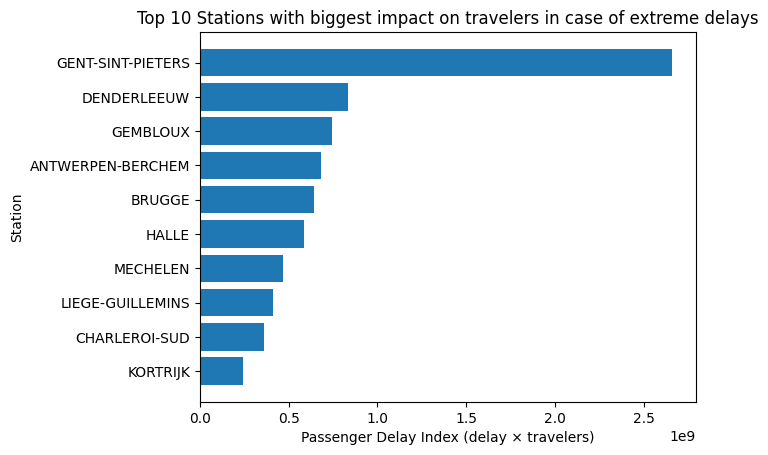

In [220]:
import matplotlib.pyplot as plt

top = priority.head(10)
plt.barh(top['place'], top['passenger_delay_index'])
plt.xlabel('Passenger Delay Index (delay × travelers)')
plt.ylabel('Station')
plt.title('Top 10 Stations with biggest impact on travelers in case of extreme delays')
plt.gca().invert_yaxis()
plt.show()
